# Algorithms in Structural Biology
## Homework 1
### Question 1: RNA Folding
#### Andrinopoulou Christina (ds2200013)

In [1]:
import numpy as np
import pandas as pd
import os
import math
%matplotlib inline
import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi

In [2]:
class Zuker:
    def __init__(self, seq='AGCU', dist_const=1):
        self.counter = 0
        self.seq = seq
        self.dist_const = dist_const
        self.length_of_seq = len(seq)
        self.W = self.initialize_matrix()
        self.V = self.initialize_matrix()
        self.path = np.zeros((self.length_of_seq,self.length_of_seq), 'U1')
        self.path.fill
        self.backpath = np.zeros((self.length_of_seq,self.length_of_seq), 'U1')
        self.backpath.fill
        self.dot_brackets = '.'*self.length_of_seq
        self.watson_crick = ['GC', 'CG', 'AU', 'UA']
        self.GU = ['GU', 'UG']
        
    
    # initialize a matrix (W/V) based on the curvature rule: j+distance < i
    def initialize_matrix(self):
        # create a matrix with NAN
        matrix = np.empty((self.length_of_seq, self.length_of_seq))
        matrix[:] = np.NaN

        # if j + 5 > i -> inf
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if j + self.dist_const > i:
                    matrix[i,j] = np.inf
        return matrix
    
           
    # hairpin energy: h(i,j) = 2(i-j+5)
    def hairpin_energy(self, i, j):
        return 2*(i-j+5)

    
    # stem energy: s(i,j) -4 (watson-crick), 0 (GU/UG), 4 (otherwise)
    def stem_energy(self, i, j):
        if self.seq[i] + self.seq[j] in self.watson_crick:
            return -4
        if self.seq[i] + self.seq[j] in self.GU:
            return 0
        else:
            return 4
    
    
    # energy of structures: 
    # for hairping V(i,j) = s(i,j) + h(i-1,j+1)
    # for match V(i,j) = s(i,j) + W(i-1,j+1)
    def V_function(self, i, j):
        hairpin = self.stem_energy(i, j) + self.hairpin_energy(i-1, j+1)
        match = self.stem_energy(i, j) + self.W[i-1, j+1]
        if hairpin < match:
            self.V[i,j] = hairpin
            return 'H'
        else:
            self.V[i,j] = match
            return 'M'
    

    def W_function(self, i, j):
        structure = self.V_function(i, j) # third choice

        # forth choice
        k_value_dict = dict()
        for k in range(j+2, i):
            if k not in k_value_dict:
                k_value_dict[k] = self.W[i,k] + self.W[k-1,j]
        min_k = min(k_value_dict.keys(), key=(lambda k: k_value_dict[k]))

        # update W with the minimum choice
        self.W[i,j] = min(self.W[i-1,j], self.W[i,j+1], self.V[i,j], k_value_dict[min_k])
        
        if self.W[i,j] == self.W[i-1,j]:
            self.path[i,j] = 'L'
        if self.W[i,j] == self.W[i,j+1]:
            self.path[i,j] = 'D'
        if self.W[i,j] == self.V[i,j]:
            self.path[i,j] = structure
        if self.W[i,j] == k_value_dict[min_k]:
            self.path[i,j] = str(min_k)
            

        
    def Zuker_algorithm(self):
        final_cell = self.W[self.length_of_seq - 1, 0]

        while math.isnan(final_cell):
            for i in range(self.length_of_seq):
                for j in range(self.length_of_seq):
                    if j + self.dist_const <= i: 
                        down = self.W[i,j+1]
                        left = self.W[i-1,j]
                        if math.isnan(down) or math.isnan(left):
                            continue
                        self.W_function(i,j)
                final_cell = self.W[self.length_of_seq - 1, 0]
                
        self.plot_RNA_secondary_structure()

                
    def backtracking(self):
        matches = []
        
        current_x = 0
        current_y = self.length_of_seq - 1
        current_cell = self.path[current_x, current_y]
        self.path = self.path.transpose()
        self.backpath[current_x, current_y] = '#'
        
        while current_cell != 'H':
            if current_cell == 'M':
                matches.append((current_x, current_y))
                current_x = current_x + 1
                current_y = current_y - 1
            if current_cell == 'L':
                current_y = current_y - 1
            if current_cell == 'D':
                current_x = current_x + 1
            current_cell = self.path[current_x, current_y]
            self.backpath[current_x, current_y] = '#'
            
            
        # hairpin
        hairpin = (current_x, current_y)
        return matches, hairpin
    
    
    def dot_bracket_converter(self):
        matches, hairpin = self.backtracking()
        for match in matches:
            first_parenthesis = match[0]
            second_parenthesis = match[1]
            dot_brackets_temp = list(self.dot_brackets)
            dot_brackets_temp[first_parenthesis] = '('
            dot_brackets_temp[second_parenthesis] = ')'
            self.dot_brackets = "".join(dot_brackets_temp)
        
        
    def plot_RNA_secondary_structure(self):
        self.dot_bracket_converter()
                
        f = open("./structure.fx", "a")
        f.write('>rna\n')
        f.write(self.seq+'\n')
        f.write(self.dot_brackets)
        f.close()
        
        cg = forgi.load_rna("./structure.fx", allow_many=False)
        fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.9,
                     backbone_kwargs={"linewidth":1})
        plt.title('RNA Secondary Structure')
        plt.show()

        os.remove('./structure.fx')
        
    
    def get_params(self):
        return {'Sequence': self.seq, 
                'Distant_constant_for_Curvature': self.dist_const,
                'Length_of_Sequence': self.length_of_seq,
                'W': pd.DataFrame(self.W.transpose()),
                'V': pd.DataFrame(self.V.transpose()),
                'Path': pd.DataFrame(self.path),
                'Backtracking':pd.DataFrame(self.backpath)} 

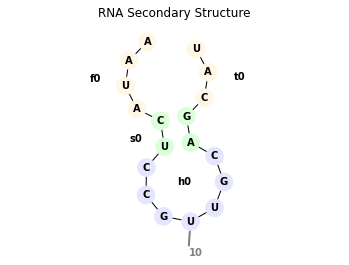

################################################### W ###################################################
     0    1    2    3    4     5     6     7     8     9     10    11    12    13    14    15    16    17
0   inf  inf  inf  inf  inf  12.0  12.0  12.0  12.0  12.0  10.0  10.0  10.0   8.0   4.0   4.0   0.0  -4.0
1   inf  inf  inf  inf  inf   inf  20.0  20.0  18.0  14.0  10.0  10.0  10.0   8.0   4.0   4.0   0.0  -4.0
2   inf  inf  inf  inf  inf   inf   inf  20.0  18.0  14.0  14.0  12.0  12.0   8.0   4.0   4.0   0.0   0.0
3   inf  inf  inf  inf  inf   inf   inf   inf  20.0  14.0  14.0  12.0  12.0   8.0   4.0   4.0   4.0   0.0
4   inf  inf  inf  inf  inf   inf   inf   inf   inf  20.0  20.0  12.0  12.0   8.0   4.0   4.0   4.0   4.0
5   inf  inf  inf  inf  inf   inf   inf   inf   inf   inf  20.0  12.0  12.0   8.0   8.0   8.0   8.0   8.0
6   inf  inf  inf  inf  inf   inf   inf   inf   inf   inf   inf  12.0  12.0  12.0  12.0  12.0  12.0  12.0
7   inf  inf  inf  inf  inf   inf   inf   inf 

In [3]:
zuker = Zuker(seq='AAUACUCCGUUGCAGCAU', dist_const=5)
zuker.Zuker_algorithm()
params = zuker.get_params()
header = '#'*51 
print(header+' W '+header)
print(params['W'].to_string())
print(header+' V '+header)
print(params['V'].to_string())
print(header+' Path '+header)
print(params['Backtracking'].to_string())